<a href="https://colab.research.google.com/github/Min-ju-Kim/AIFFEL_Going-Deeper/blob/main/3.%20Class%20Activation%20Map%20/%20%5BGD_6%5DClassActivationMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Going Deeper 6. Class Activation Map

### Table of Contents

### 1. Experiment Environment Set-up
* 1.1 Import Libraries

### 2. Preparing Models for CAM, Grad-CAM
* 2.1 Prepare the Dataset
* 2.2 Object Location Information
* 2.3 Creating Model for CAM
* 2.4 Training the CAM

### 3. CAM (Class Activation Map)

### 4. Grad-CAM (Grad-Class Activation Map)

### 5. Detection with CAM
* 5.1 Bounding box
* 5.2 Intersection Over Union (IoU)

### 6. Conclusion

### 7. Retrospection

****

### 1. Experiment Environment Set-up


### 1.1 Import Libraries

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
import os
from PIL import Image

### 2. Preparing Models for CAM, Grad-CAM

### 2.1 Prepare the Dataset

* [stanford_dogs in Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/stanford_dogs)
  * TensorflowÏùò Îç∞Ïù¥ÌÑ∞ÏÖã
  * 120 Ï¢ÖÏùò Í∞ú ÏÇ¨ÏßÑ
  * ÎùºÎ≤®Ïù¥ ÏúÑÏπò Ï†ïÎ≥¥Ïù∏ **Î∞îÏö¥Îî© Î∞ïÏä§(bounding box)** Ï†ïÎ≥¥Î•º Ìè¨Ìï®

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# ÏµúÏ¥à ÏàòÌñâ ÏãúÏóêÎäî Îã§Ïö¥Î°úÎìúÍ∞Ä ÏßÑÌñâ
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete293PTH/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete293PTH/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


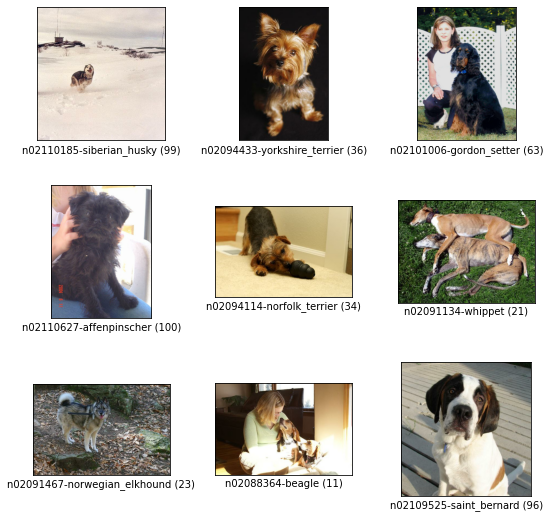

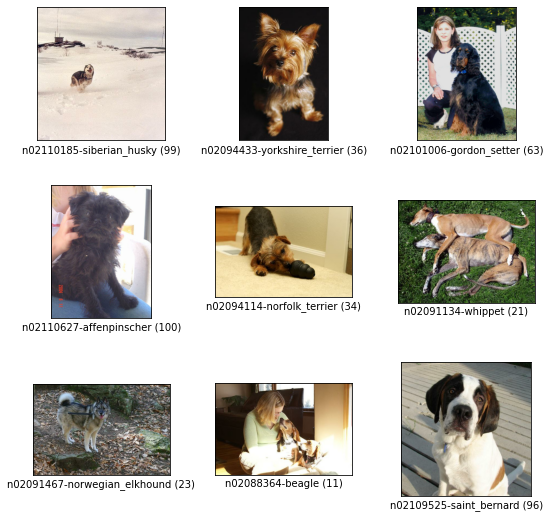

In [ ]:
# tfds.show_examples()Î•º ÌÜµÌï¥ Í∞Å Ïù¥ÎØ∏ÏßÄÏùò ÌÅ¥ÎûòÏä§ÏôÄ Í∑∏ Ïù∏Îç±Ïä§ ÌôïÏù∏ Í∞ÄÎä•
tfds.show_examples(ds_train, ds_info)

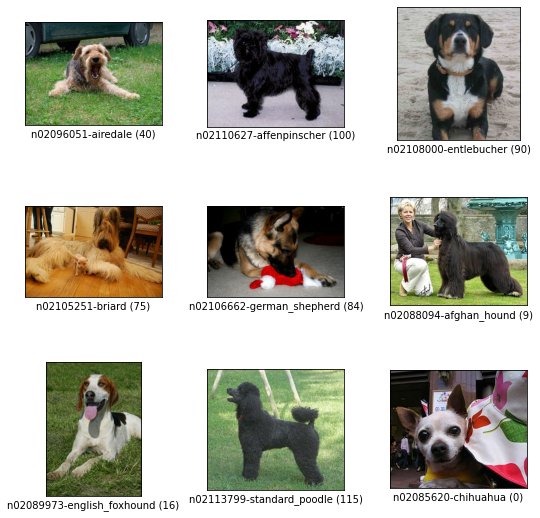

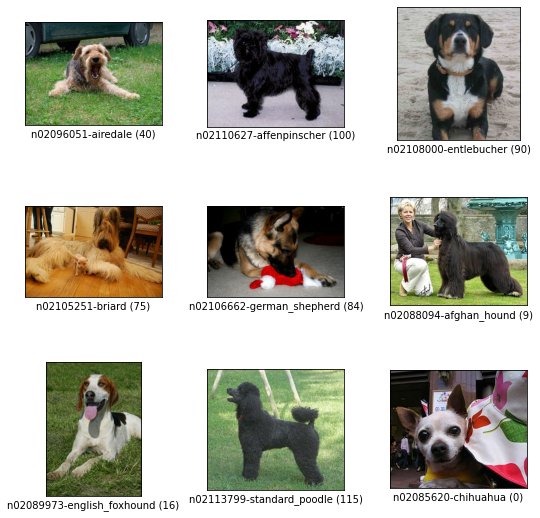

In [ ]:
# ÌèâÍ∞ÄÏö© Îç∞Ïù¥ÌÑ∞ÏÖãÎèÑ ÎààÏúºÎ°ú ÌôïÏù∏Ìï¥Î≥∏Îã§.
tfds.show_examples(ds_test, ds_info)

### 2.2 Object Location Information

In [ ]:
# Îç∞Ïù¥ÌÑ∞ÏÖãÏùò Î©îÌÉÄÏ†ïÎ≥¥Ïù∏ df_infoÎ•º Ï°∞ÌöåÌï¥ featureÍ∞Ä Ïñ¥ÎñªÍ≤å Íµ¨ÏÑ±ÎêòÏñ¥ ÏûàÎäîÏßÄ ÌôïÏù∏
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

* `image`ÏôÄ `label`ÏùÄ ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄÏôÄ Ïù¥ÎØ∏ÏßÄÏóê Ìï¥ÎãπÌïòÎäî Ï†ïÎãµ ÌÅ¥ÎûòÏä§Ïùò Ïù∏Îç±Ïä§
* `bbox`(Î∞îÏö¥Îî© Î∞ïÏä§)Îäî Î¨ºÏ≤¥Ïùò ÏúÑÏπòÎ•º ÏÇ¨Í∞ÅÌòï ÏòÅÏó≠ÏúºÎ°ú ÌëúÍ∏∞ÌïòÎäî Î∞©Î≤ï
* `bbox`Îäî `BBoxFeature`Ïù¥ÎùºÎäî ÌÉÄÏûÖÏúºÎ°ú Ï†ïÏùò
* `[y_min, x_min, y_max, x_max]`Î•º ÎÇòÌÉÄÎÉÑ

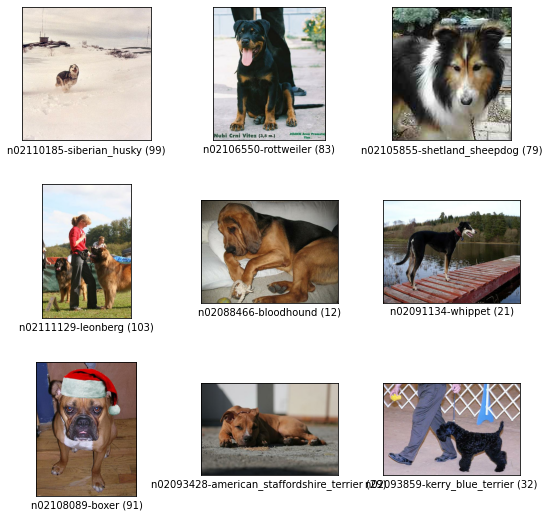

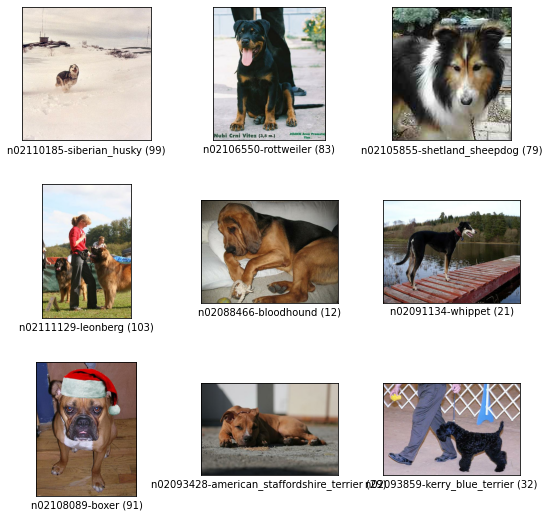

In [ ]:
# Í∞Å Ïù¥ÎØ∏ÏßÄÏùò ÌÅ¥ÎûòÏä§ÏôÄ Í∑∏ Ïù∏Îç±Ïä§ ÌôïÏù∏
tfds.show_examples(ds_train, ds_info)

### 2.3 Creating Model for CAM

* Ïù¥ÎØ∏ÏßÄÎÑ∑(ImageNet) Îç∞Ïù¥ÌÑ∞Ïóê ÌõàÎ†®Îêú `ResNet50`ÏùÑ Í∏∞Î∞ò
* Ïù¥ÌõÑÏóê pooling layer Îí§Ïóê softmax layerÎ•º Î∂ôÏó¨ Grand-CAM Î™®Îç∏ÏùÑ ÎßåÎì†Îã§.
* Ïó¨Í∏∞ÏÑú ÏÇ¨Ïö©ÌïòÎäî softmax layerÎäî softmax Ìï®ÏàòÎ•º activation functionÏúºÎ°ú ÏÇ¨Ïö©ÌïòÎäî fully connected layerÏù¥Îã§.

In [ ]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,  # ImageNet Î∂ÑÎ•òÍ∏∞ fully connected layer Ï†úÍ±∞
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'  # GAP Ï†ÅÏö©
)
x = base_model.output  # base_modelÏùÑ Í±∞Ïπú Í≤∞Í≥ºÎ•º ÏùòÎØ∏
preds = keras.layers.Dense(num_classes, activation='softmax')(x)  # softmax Ìï®ÏàòÎ•º activation functionÏúºÎ°ú ÏÇ¨Ïö©ÌïòÎäî fully connected layer
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [ ]:
# CAM model ÌôïÏù∏
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

* conv5_block3_outÏùò outputÏù¥ feature mapÏù¥ ÎêúÎã§. 
* Ïù¥ feature mapÏóê GAP(Global Average Pooling)ÏùÑ ÌïòÏó¨ featureÏùò ÌÅ¨Í∏∞Î•º Ï§ÑÏù¥Í≥†
* Ï§ÑÏñ¥Îì† feature Ï†ÑÏ≤¥Ïóê Dense layerÎ•º Î∂ôÏó¨ classificationÏùÑ ÏàòÌñâÌïúÎã§.



### 2.4 Training the CAM

In [ ]:
# normalizingÍ≥º resizingÏùÑ Ìè¨Ìï®Ìïú Ï†ÑÏ≤òÎ¶¨ normalize_and_resize_img() ÏàòÌñâ
def normalize_and_resize_img(input):
    # Normalize image: `unit8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])  # Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞ 224, 224Î°ú Î≥ÄÍ≤Ω
    input['image'] = tf.cast(image, tf.float32) / 255.   # Ïù¥ÎØ∏ÏßÄ ÌîΩÏÖÄ Í∞í 0~1ÏÇ¨Ïù¥Î°ú Ï†ïÍ∑úÌôî
    return input['image'], input['label'] 

# apply_normalize_on_dataset()ÏóêÏÑú Î∞∞Ïπò Íµ¨ÏÑ±
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200) 
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('üå∏~')

üå∏~


In [ ]:
# Îç∞Ïù¥ÌÑ∞ÏÖãÏóê Ï†ÑÏ≤òÎ¶¨ÏôÄ Î∞∞ÏπòÏ≤òÎ¶¨ Ï†ÅÏö©
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [ ]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

print('üå∏~')

üå∏~


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 129s 143ms/step - loss: 2.1697 - accuracy: 0.4552 - val_loss: 3.0347 - val_accuracy: 0.2590
Epoch 2/20
750/750 [==============================] - 101s 135ms/step - loss: 0.6691 - accuracy: 0.8192 - val_loss: 1.0193 - val_accuracy: 0.6984
Epoch 3/20
750/750 [==============================] - 101s 135ms/step - loss: 0.2377 - accuracy: 0.9499 - val_loss: 0.9643 - val_accuracy: 0.7171
Epoch 4/20
750/750 [==============================] - 101s 135ms/step - loss: 0.0863 - accuracy: 0.9899 - val_loss: 0.9169 - val_accuracy: 0.7346
Epoch 5/20
750/750 [==============================] - 102s 135ms/step - loss: 0.0515 - accuracy: 0.9952 - val_loss: 0.9497 - val_accuracy: 0.7307
Epoch 6/20
750/750 [==============================] - 102s 136ms/step - loss: 0.0246 - accuracy: 0.9983 - val_loss: 0.9054 - val_accuracy: 0.7471
Epoch 7/20
750/750 [==============================] - 101s 135ms/step - loss: 0.0114 - accuracy: 0.9998 - val_loss: 0.9024 -

In [ ]:
# ÌïôÏäµÏãúÌÇ® Í∞ÄÏ§ëÏπò Ï†ÄÏû•
cam_model_path = '/content/sample_data.cam_model1.h5'
cam_model.save(cam_model_path)#

print('üå∏~')

üå∏~


### 3. CAM (Class Activation Map)

In [ ]:
import urllib3

urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
# ÌïôÏäµÎêú Î™®Îç∏ÏóêÏÑú CAM ÏÉùÏÑ±
# CAM ÏÉùÏÑ± ÏûëÏóÖÏùÄ Îç∞Ïù¥ÌÑ∞ÏÖã Î∞∞Ïπò Îã®ÏúÑÍ∞Ä ÏïÑÎãàÎùº Í∞úÎ≥Ñ Ïù¥ÎØ∏ÏßÄ Îç∞Ïù¥ÌÑ∞ Îã®ÏúÑÎ°ú Ïù¥Î£®Ïñ¥ÏßÑÎã§.
# Îî∞ÎùºÏÑú `get_one()`Ìï®ÏàòÎ°ú Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑú Ìïú Ïû•Ïî© ÎΩëÏùÑ Ïàò ÏûàÎèÑÎ°ù ÌñàÎã§.
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())  # numpyÌòïÌÉúÎ°ú Î≥ÄÌôò
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('üå∏~')

üå∏~


108


<function matplotlib.pyplot.show>

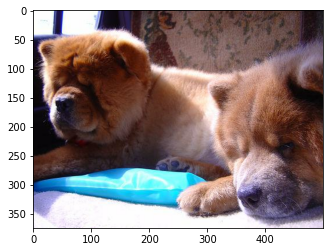

In [ ]:
# Îç∞Ïù¥ÌÑ∞ ÌïòÎÇòÎ•º Í∞ÄÏ†∏ÏôÄ ÏãúÍ∞ÅÌôî
item = get_one(ds_test)  # ds_testÎ•º ÏßëÏñ¥ÎÑ£ÎäîÎã§(normalize, resize Ï†ÅÏö©ÌïòÏßÄ X), numpyÌòïÌÉúÎ°ú Î≥ÄÌôòÎêúÎã§.
print(item['label'])
plt.imshow(item['image'])
plt.show

In [ ]:
# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑÍ∞Ä ÏôÑÎ£åÎêòÏóàÏúºÎØÄÎ°ú ÌïôÏäµÌïú Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞
cam_model.save(cam_model_path)

print('üå∏~')

üå∏~


<p align='middle'><img src = 'https://media.vlpt.us/images/mjk3136/post/60e1a691-e245-437e-bef2-194d582fecb2/image.png' width='650'></p>

* CAMÏùÑ ÏÉùÏÑ±ÌïòÍ∏∞ ÏúÑÌï¥ ÌïÑÏöîÌïú Í≤É
1. ÌäπÏÑ± Îßµ
2. ÌÅ¥ÎûòÏä§Î≥Ñ ÌôïÎ•†ÏùÑ ÏñªÍ∏∞ ÏúÑÌïú ÏÜåÌîÑÌä∏Îß•Ïä§ Î†àÏù¥Ïñ¥Ïùò Í∞ÄÏ§ëÏπò
3. ÏõêÌïòÎäî ÌÅ¥ÎûòÏä§Ïùò Ï∂úÎ†•Í∞í

| Layer (type) | Output Shape | Param # | Connected to | - |
| :--: | :--: | :--: | :--: | :--: | 
|conv5_block3_out (Activation) | (None, 7, 7, 2048) | 0 | conv5_block3_add[0][0] | (activation map) |           
|avg_pool (GlobalAveragePooling2) | (None, 2048) | 0 | conv5_block3_out[0][0] | - |           
|dense (Dense) | (None, 120) | 245880 | avg_pool[0][0] | (softmax layer) |

In [ ]:
def generate_cam(model, item):  # Ïó¨Í∏∞ÏÑú itemÏùÄ `get_one`Ìï®ÏàòÎ•º ÌÜµÍ≥ºÌïú ÌõÑÏùò Í≤∞Í≥ºÍ∞í
    item = copy.deepcopy(item)  # ÌååÏù¥Ïç¨ ÎÇ¥Ïû• ÌÅ¥ÎûòÏä§ copy
    # image.shape = (height, width, channels)  listÏïÑÎãåÍ∞Ä?
    width = item['image'].shape[1]
    height = item['image'].shape[0]

    # normalize_and_resize_imgÏùò returnÍ∞í : input['image'], input['label']
    # img_tensor(type:tensor, shape:(224, 224, 3)) = item['image'], class_idx(type:tensor, shape:(1, 120)) = item['label']
    img_tensor, class_idx = normalize_and_resize_img(item)  

    # ÌïôÏäµÌïú Î™®Îç∏ÏóêÏÑú ÏõêÌïòÎäî LayerÏùò outputÏùÑ ÏñªÍ∏∞ ÏúÑÌï¥ÏÑú Î™®Îç∏Ïùò inputÍ≥º outputÏùÑ ÏÉàÎ°≠Í≤å Ï†ïÏùò
    # model.layer[-3].output : GAP Ïù¥Ï†Ñ Convolution layerÏùò output (activation map)
    # cam_model = keras.Model(input=base_model.input, outputs=preds)
    # conv_outputs = activation map
    # predicts = softmax layerÎ•º ÌÜµÍ≥ºÌïú output
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])  # Î™®Îç∏Ïùò inputÍ≥º outputÏùÑ ÏÉàÎ°≠Í≤å Ï†ïÏùò 
    conv_outputs, predicts = cam_model(tf.expand_dims(img_tensor, 0))  # tf.expand_dims(img_tensor, 0) : [1, -, -, -] / [-, -, -] : img_tensor.shape
    
    conv_outputs = conv_outputs[0, :, :, :]  # ÏïûÏóêÏÑú Ï∂îÍ∞ÄÌñàÎçò Ï∂ïÏùÑ Ï†úÏô∏ÌïòÍ≥† Î∞õÏïÑÏò®Îã§. ((7, 7, 2048))
    class_weights = model.layers[-1].get_weights()[0]  # ÎßàÏßÄÎßâ Î™®Îç∏Ïùò weight activationÏùÑ Í∞ÄÏ†∏Ïò®Îã§. (softmaxÏùò Í∞ÄÏ§ëÏπò)
                                                       # get_weights()[1] Ïùò Í≤ΩÏö∞ bis Ìï¥Îãπ
                                                       # class_weight: shape = (2048, 120), type = numpy.ndarray
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])  # conv_outputs.shape[0:2] = (7, 7)
    for i, w in enumerate(class_weights[:, class_idx]):  # class_weights[:, class_idx] = ÌñâÏùÄ Ï†ÑÎ∂Ä Îã§, Ïó¥ÏùÄ class_idxÏóê Ìï¥ÎãπÌïòÎäî Ïó¥ÏùÑ Í∞ÄÏ†∏Ïò®Îã§. (2048,)
        # W*fÎ•º ÌÜµÌï¥ classÎ≥Ñ activation mapÏùÑ Í≥ÑÏÇ∞ÌïúÎã§.
        cam_image += w * conv_outputs[:, :, i]  
    
    cam_image /= np.max(cam_image)  # activation scoreÎ•º normalizeÌïúÎã§.
    cam_image = cam_image.numpy()  
    cam_image = cv2.resize(cam_image, (width, height))  # ÏõêÎûò Ïù¥ÎØ∏ÏßÄÏùò ÌÅ¨Í∏∞Î°ú resize
    return cam_image

print('üå∏~')

üå∏~


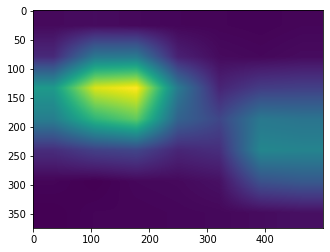

In [ ]:
# CAM Ïù¥ÎØ∏ÏßÄ ÌôïÏù∏
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [ ]:
# Í∑∏Î†§ÏßÑ CAM Ïù¥ÎØ∏ÏßÄÎ•º ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÏôÄ Ìï©Ï≥êÎ≥∏Îã§.
def visualize_cam_on_img(src1, src2, alpha=0.5):
    beta = (1.0-alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

print('üå∏~')

üå∏~


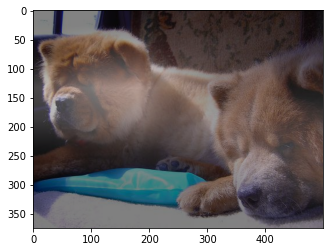

In [ ]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_img(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### 4. Grad-CAM (Grad-Class Activation Map)

67


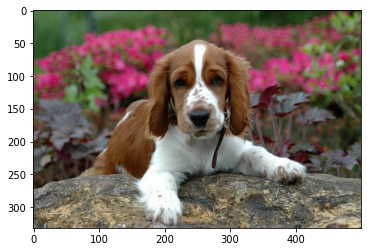

In [ ]:
# Ïö∞ÏÑ† ÏÉàÎ°úÏö¥ Ïù¥ÎØ∏ÏßÄÎ•º ÎΩëÏïÑÎ≥∏Îã§.
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

* `grad_cam`ÏùÄ Í¥ÄÏ∞∞ÏùÑ ÏõêÌïòÎäî Î†àÏù¥Ïñ¥ÏôÄ Ï†ïÎãµ ÌÅ¥ÎûòÏä§Ïóê ÎåÄÌïú ÏòàÏ∏°Í∞í ÏÇ¨Ïù¥Ïùò Í∑∏ÎûòÎîîÏñ∏Ìä∏Î•º Íµ¨ÌïòÍ≥†,
* Ïó¨Í∏∞Ïóê GAP Ïó∞ÏÇ∞ÏùÑ Ï†ÅÏö©Ìï®ÏúºÎ°úÏç® Í¥ÄÏ∞∞ ÎåÄÏÉÅÏù¥ ÎêòÎäî Î†àÏù¥Ïñ¥Ïùò Ï±ÑÎÑêÎ≥Ñ Í∞ÄÏ§ëÏπòÎ•º Íµ¨ÌïúÎã§.
* ÏµúÏ¢Ö CAM Ïù¥ÎØ∏ÏßÄÎ•º Íµ¨ÌïòÍ∏∞ ÏúÑÌï¥ÏÑúÎäî Î†àÏù¥Ïñ¥Ïùò Ï±ÑÎÑêÎ≥Ñ Í∞ÄÏ§ëÏπò(`weights`)ÏôÄ Î†àÏù¥Ïñ¥ÏóêÏÑú ÎÇòÏò® ÌäπÏÑ±Î≥Ñ ÌäπÏÑ± ÎßµÏùÑ Í∞ÄÏ§ëÌï©Ìï¥Ï£ºÏñ¥ `cam_image`Î•º ÏñªÍ≤å ÎêúÎã§.

* Í∑∏ÎûòÎîîÏñ∏Ìä∏ Í≥ÑÏÇ∞ÏùÑ ÏõêÌïòÎäî Í¥ÄÏ∞∞ ÎåÄÏÉÅ Î†àÏù¥Ïñ¥ `activation_layer`Î•º ÎΩëÏïÑÏÑú Ïì∏ Ïàò ÏûàÎèÑÎ°ù `activation_layer`Ïùò Ïù¥Î¶ÑÏùÑ Î∞õÍ≥† Ïù¥Î•º ÌôúÏö©Ìï¥Ïïº ÌïúÎã§.
* `generate_grad_cam()`ÏóêÏÑúÎäî ÏõêÌïòÎäî Î†àÏù¥Ïñ¥Ïùò `output`Í≥º ÌäπÏ†ï ÌÅ¥ÎûòÏä§Ïùò prediction ÏÇ¨Ïù¥Ïùò Í∑∏ÎûòÎîîÏñ∏Ìä∏ `grad_val`ÏùÑ ÏñªÍ≥† Ïù¥Î•º `weights`Î°§ ÌôúÏö©ÌïúÎã§.

<p align='middle'><img src='https://d3s0tskafalll9.cloudfront.net/media/images/GC-3-L-9.max-800x600.png' height='230'></p>

In [ ]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])

    # GradientÎ•º ÏñªÍ∏∞ ÏúÑÌï¥ tapeÎ•º ÏÇ¨Ïö©ÌïúÎã§.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor,0))

        loss = pred[:, class_idx]  # ÏõêÌïòÎäî class(Ïó¨Í∏∞ÏÑúÎäî Ï†ïÎãµÏúºÎ°ú ÌôúÏö©) ÏòàÏ∏°Í∞íÏùÑ ÏñªÎäîÎã§.
        output = conv_output[0]  # ÏõêÌïòÎäî layerÏùò outputÏùÑ ÏñªÎäîÎã§.
        grad_val = tape.gradient(loss, conv_output)[0]  # ÏòàÏ∏°Í∞íÏóê Îî∞Î•∏ LayerÏùò gradientÎ•º ÏñªÎäîÎã§.

    weights = np.mean(grad_val, axis=(0,1))  # gradientÏùò GAPÏúºÎ°ú classÎ≥Ñ weightÎ•º Íµ¨ÌïúÎã§.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # Í∞Å classÎ≥Ñ weightÏôÄ Ìï¥Îãπ layerÏùò outputÏùÑ Í≥±Ìï¥ class activation mapÏùÑ ÏñªÎäîÎã§.
        grad_cam_image += w * output[:, :, k]
    
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('üå∏~')

üå∏~


* Î†àÏù¥Ïñ¥Ïùò Ïù¥Î¶ÑÏùÄ Ïù¥Ï†Ñ Ïä§ÌÉ≠Ïùò `cam_model.summary()` Í≤∞Í≥ºÏóêÏÑú Ï∞æÏùÑ Ïàò ÏûàÎã§. 

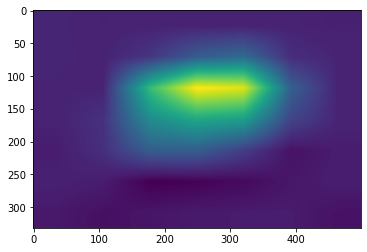

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

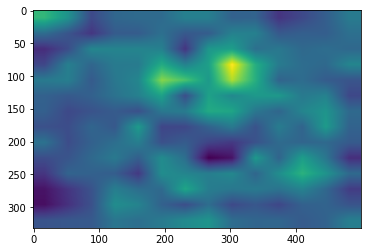

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

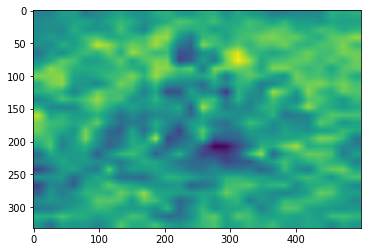

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

### 5. Detection with CAM

### 5.1 Bounding box

67


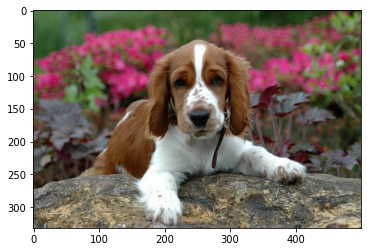

In [ ]:
# Ïö∞ÏÑ† ÏÉàÎ°úÏö¥ Ïù¥ÎØ∏ÏßÄÎ•º Îã§Ïãú ÎΩëÏïÑ CAM Ïù¥ÎØ∏ÏßÄÎ•º ÎΩëÏïÑÎ≥∏Îã§.
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

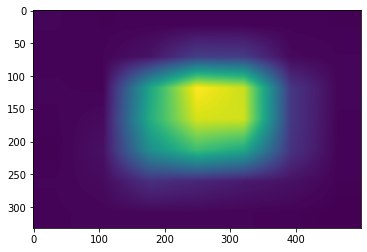

In [ ]:
# Ïù¥Ï†Ñ Ïä§ÌÖùÏóêÏÑú ÎßåÎì§ÏóàÎçò `generate_cam()`ÏùÑ ÌôúÏö©Ìï¥ÏÑú CAM Ïù¥ÎØ∏ÏßÄÎ•º ÎΩëÎäîÎã§. 
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

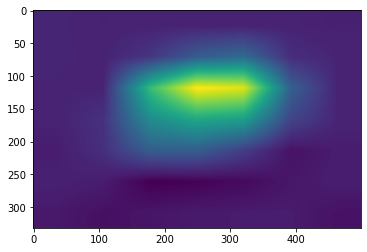

In [ ]:
# Ïù¥Ï†Ñ Ïä§ÌÖùÏóêÏÑú ÎßåÎì§ÏóàÎçò `generate_grad_cam()`ÏùÑ ÌôúÏö©Ìï¥ÏÑú Grad-CAM Ïù¥ÎØ∏ÏßÄÎ•º ÎΩëÎäîÎã§. 
# ÌäπÏÑ± ÎßµÏùÑ ÎΩëÏïÑÏò§Îäî ÏúÑÏπòÎäî CAMÍ≥º ÎèôÏùºÌïòÍ≤å ÏÑ§Ï†ï
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

* `get_bbox()`Ìï®ÏàòÎäî Î∞îÏö¥Îî© Î∞ïÏä§Î•º ÎßåÎì§Í∏∞ ÏúÑÌï¥ `score_thresh`Î•º Î∞õÏïÑ Ïó≠ÏπòÍ∞í Ïù¥ÌïòÏùò Î∞îÏö¥Îî© Î∞ïÏä§Îäî ÏóÜÏï§Îã§.
* OpenCVÏùò `findContours()`ÏôÄ `minAreaRect()`Î°ú ÏÇ¨Í∞ÅÌòïÏùÑ Ï∞æÎäîÎã§.
* Ïù¥Îïå `rotated_rect`ÎùºÎäî ÌöåÏ†ÑÎêú Î∞îÏö¥Îî© Î∞ïÏä§Î•º ÏñªÏùÑ Ïàò ÏûàÎã§.
* `boxPoints()`Î°ú Ïù¥Î•º Íº≠ÏßÄÏ†êÏúºÎ°ú Î∞îÍæ∏Ïñ¥ Ï§ÄÎã§.
* ÎßàÏßÄÎßâÏóêÎäî `int` ÏûêÎ£åÌñ•ÏúºÎ°ú Î≥ÄÌôòÌï¥Ï§ÄÎã§.

In [ ]:
def get_bbox(cam_image, score_thresh=0.5):
    low_indicies = cam_image <= score_thresh  # Ïó≠ÏπòÍ∞í Ïù¥ÌïòÏùò Î∞îÏö¥Îî© Î∞ïÏä§Îäî ÏóÜÏï§Îã§.
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)

    # Ïú§Í≥ΩÏÑ†Îßå Î≥ÄÏàò contoursÎ°ú Î∞õÏïÑÏò®Îã§.
    contours, _ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)  # ÏµúÏÜåÌïúÏùò ÏÇ¨Í∞ÅÌòï ÌëúÏãú, ÌöåÏ†ÑÎêú Î∞îÏö¥Îî© Î∞ïÏä§ ÏñªÍ∏∞
    rect = cv2.boxPoints(rotated_rect)  # Ï§ëÏã¨Ï†êÍ≥º Í∞ÅÎèÑÎ•º 4Í∞úÏùò Íº≠ÏßÄÏ†ê Ï¢åÌëúÎ°ú Î≥ÄÌôò
    rect = np.int0(rect)  # Ï†ïÏàòÎ°ú Î≥ÄÌôò
    return rect

print('üå∏~')

üå∏~


In [ ]:
# CAMÏùò bboxÎ•º ÏñªÎäîÎã§.
rect = get_bbox(cam_image)
rect

array([[165, 227],
       [165,  90],
       [360,  90],
       [360, 227]])

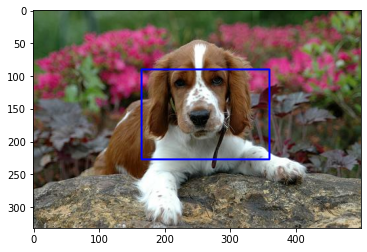

In [ ]:
# ÏñªÏñ¥ÏßÑ bboxÎ•º Ïù¥ÎØ∏ÏßÄ ÏúÑÏóê ÏãúÍ∞ÅÌôîÌïúÎã§.
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0, 0, 255), 2)
plt.imshow(image)
plt.show()

In [ ]:
# Grad-CAMÏùò bboxÎ•º ÏñªÎäîÎã§.
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[164, 175],
       [162,  90],
       [364,  85],
       [366, 170]])

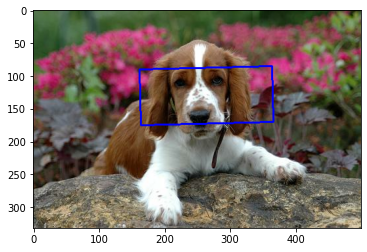

In [ ]:
# ÏñªÏñ¥ÏßÑ bboxÎ•º Ïù¥ÎØ∏ÏßÄ ÏúÑÏóê ÏãúÍ∞ÅÌôîÌïúÎã§.
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [grad_rect], 0, (0, 0, 255), 2)
plt.imshow(image)
plt.show()

### 5.2 Intersection Over Union (IoU)

<p align='middle'><img src='https://d3s0tskafalll9.cloudfront.net/media/images/GC-3-P-3.max-800x600.jpg' width='300'></p>

* Ï†ïÎãµ Îç∞Ïù¥ÌÑ∞Ïù∏ Î∞îÏö¥Îî© Î∞ïÏä§ÏôÄ ÎπÑÍµêÌïòÎäî Î∞©Î≤ï
* Îëê ÏòÅÏó≠Ïùò ÍµêÏßëÌï©Ïù∏ **intersection** ÏòÅÏó≠Ïùò ÎÑìÏù¥Î•º Îëê ÏòÅÏó≠Ïùò Ìï©ÏßëÌï©Ïù∏ **union** ÏòÅÏó≠ÏúºÎ°ú ÎÇòÎàÑÏñ¥Ï§Ä Í∞í
* ÏòÅÏó≠ÏùÑ Ï†ïÌôïÌïòÍ≤å Ïûò Ï∞æÏïÑÎÇ¥ÏóàÎäîÏßÄÏùò ÏÉÅÎåÄÏ†ÅÏù∏ ÎπÑÏú®ÏùÑ Íµ¨Ìï† Ïàò ÏûàÏúºÎØÄÎ°ú, Î™®Îç∏Ïù¥ ÏòÅÏó≠ÏùÑ Ïûò Ï∞æÏïòÎäîÏßÄ ÎπÑÍµêÌïòÎäî Ï¢ãÏùÄ ÏßÄÌëúÍ∞Ä ÎêúÎã§.

In [ ]:
# rectÏùò Ï¢åÌëúÎäî (x, y) ÌòïÌÉú
# bboxÎäî (y_min, x_min, y_max, x_max)Ïùò normalize ÌòïÌÉú
# image.shape = [height, width, channels]
# rect[:,1] : 4Í∞úÏùò yÏ¢åÌëú
# rect[:,0] : 4Í∞úÏùò xÏ¢åÌëú
def rect_to_minmax(rect, image):
    bbox = [
            rect[:,1].min()/float(image.shape[0]),  # bounding boxÏùò y_min
            rect[:,0].min()/float(image.shape[1]),  # bounding boxÏùò x_min
            rect[:,1].max()/float(image.shape[0]),  # bounding boxÏùò y_max
            rect[:,0].max()/float(image.shape[1])   # bounding boxÏùò x_max          
    ]
    return bbox

print('üå∏~')

üå∏~


In [ ]:
# Ïù¥ Îç∞Ïù¥ÌÑ∞Ïùò ground truth bbox ÌôïÏù∏
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [ ]:
# CAMÏùò bbox
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.2710843373493976, 0.33, 0.6837349397590361, 0.72]

In [ ]:
# Grad-CAMÏùò bbox
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
grad_pred_bbox

[0.2560240963855422, 0.324, 0.5271084337349398, 0.732]

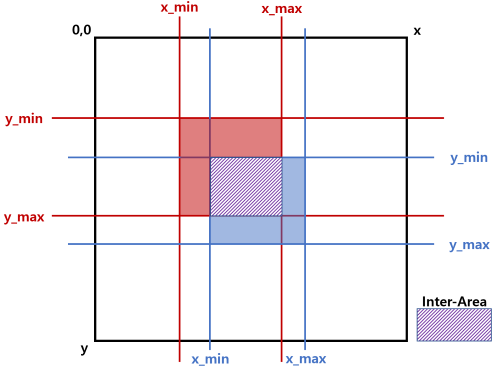

In [ ]:
# IoU Í≥ÑÏÇ∞
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min = max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])

    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print('üå∏~')

üå∏~


In [ ]:
# CAMÏúºÎ°ú ÏñªÏùÄ Î∞îÏö¥Îî© Î∞ïÏä§ÏôÄ Ï†ïÎãµ Î∞îÏö¥Îî© Î∞ïÏä§ÏôÄÏùò IoU
get_iou(pred_bbox, item['objects']['bbox'][0])

0.277644986706671

In [ ]:
# Grad-CAMÏúºÎ°ú ÏñªÏùÄ Î∞îÏö¥Îî© Î∞ïÏä§ÏôÄ Ï†ïÎãµ Î∞îÏö¥Îî© Î∞ïÏä§ÏôÄÏùò IoU
get_iou(grad_pred_bbox, item['objects']['bbox'][0])

0.19081272528296758

### 6. Conclusion

* Ï¢åÌëúÎßå ÌôïÏù∏ÌñàÏùÑ Ïãú CAM, Grad-CAMÏùò Î∞îÏö¥Îî© Î∞ïÏä§ÏôÄ Ï†ïÎãµ Î∞îÏö¥Îî© Î∞ïÏä§Ïùò Ï¢åÌëúÍ∞Ä ÌÅ¨Í≤å Ï∞®Ïù¥ÎÇòÏßÄ ÏïäÎäîÎã§.
* IoU ÌôïÏù∏ Ïãú Grad-CAMÎ≥¥Îã§ CAMÏù¥ Ï†ïÎãµ Î∞îÏö¥Îî© Î∞ïÏä§ÏôÄ Îçî Í≤πÏπòÎäî Î∂ÄÎ∂ÑÏù¥ ÎßéÏùåÏùÑ Ïïå Ïàò ÏûàÎã§.
* Grad-CAMÏùò Í≤ΩÏö∞Í∞Ä Ïù¥ÎØ∏ÏßÄÏùò ÌäπÏÑ± Î∂ÄÎ∂ÑÏóê Îçî ÏßëÏ§ëÎêòÎäî Í≤ΩÌñ•Ïù¥ ÏûàÎäî Í≤É Í∞ôÎã§.
* CAMÍ≥º Grad-CAMÏùò ÌäπÏÑ± ÎßµÏùÑ ÏñªÏñ¥ÎÇ¥Îäî Î∞©ÏãùÏóê ÏïΩÍ∞Ñ Ï∞®Ïù¥Í∞Ä ÏûàÏúºÎÇò Í≤∞Í≥ºÎ¨ºÏùÄ ÌÅ¨Í≤å Ï∞®Ïù¥Í∞Ä ÏóÜÏùåÏùÑ Ïïå Ïàò ÏûàÎã§. (Ï∂úÎ†•Îêú ÌäπÏÑ±Îßµ Î∞è IoUÌôïÏù∏ Ïãú)

### 7. Retrospection

### 7.1 What was difficult

* Ï¢åÌëúÍ∞íÏùÑ Î∞îÏö¥Îî© Î∞ïÏä§Î°ú ÌëúÌòÑÌïòÍ∏∞ ÏúÑÌï¥ Î≥ÄÌôòÏãúÌÇ§Îäî Î∂ÄÎ∂ÑÏù¥ Ï¢Ä Ïñ¥Î†§Ïõ†Îã§.

### 7.2 What I found out

1. `Model.fit(verbose='auto')`
* verbose: 'auto', 0, 1, or 2 
* Verbosity mode. 
* 0 = silent, 
* 1 = progress bar, 
* 2 = one line per epoch
* 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy

2. `tf.data.Dataset.as_numpy_iterator()`
* Îç∞Ïù¥ÌÑ∞ ÏÑ∏Ìä∏Ïùò Î™®Îì† ÏöîÏÜåÎ•º ‚Äã‚ÄãnumpyÎ°ú Î≥ÄÌôòÌïú iteratorÎ•º Î∞òÌôòÌïúÎã§.

3. Deepcopy
* ÏñïÏùÄ Î≥µÏÇ¨ÏôÄ ÍπäÏùÄ Î≥µÏÇ¨Ïùò Ï∞®Ïù¥Ï†êÏùÄ Î≥µÌï© Í∞ùÏ≤¥ (Î™©Î°ù ÎòêÎäî ÌÅ¥ÎûòÏä§ Ïù∏Ïä§ÌÑ¥Ïä§ÏôÄ Í∞ôÏùÄ Îã§Î•∏ Í∞ùÏ≤¥Î•º Ìè¨Ìï®ÌïòÎäî Í∞ùÏ≤¥)ÏóêÎßå Ìï¥ÎãπÎêúÎã§.
  * ÏñïÏùÄ Î≥µÏÇ¨Î≥∏ÏùÄ ÏÉà Î≥µÌï© Í∞úÏ≤¥Î•º Íµ¨ÏÑ±Ìïú Îã§Ïùå Í∞ÄÎä•Ìïú Ìïú ÏõêÎ≥∏ Í∞úÏ≤¥ÏóêÏÑú Ï∞æÏùÄ Í∞úÏ≤¥Ïóê Ï∞∏Ï°∞Î•º ÏÇΩÏûÖÌïúÎã§.
  * Îî• Ïπ¥ÌîºÎäî ÏÉà Î≥µÌï© Í∞ùÏ≤¥Î•º Íµ¨ÏÑ±Ìïú Îã§Ïùå Ïû¨Í∑Ä Ï†ÅÏúºÎ°ú ÏõêÎ≥∏ÏóêÏÑú Ï∞æÏùÄ Í∞ùÏ≤¥Ïùò Ïπ¥ÌîºÎ•º Î≥µÏÇ¨ÌïúÎã§.
* https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=websearch&logNo=222140334361

4. `tf.expand_dims()`
```python
tf.expand_dims(
    input, axis, name=None
)
```
* Ïù∏Îç±Ïä§ Ï∂ïÏóê Í∏∏Ïù¥ 1 Ï∂ïÏù¥ ÏÇΩÏûÖÎêú ÌÖêÏÑúÎ•º Î∞òÌôòÌïúÎã§.
* ÏòàÏãú
```python
>>> image = tf.zeros([10,10,3])
>>> tf.expand_dims(image, axis=0).shape.as_list()
[1, 10, 10, 3]
>>> tf.expand_dims(image, axis=1).shape.as_list()
[10, 1, 10, 3]
>>> tf.expand_dims(image, -1).shape.as_list()
[10, 10, 3, 1]
```

5. `numpy.zeros()`
```python
numpy.zeros(shape, dtype=float, order='C', *, like=None)
```
* 0ÏúºÎ°ú Ï±ÑÏõåÏßÑ ÏßÄÏ†ïÎêú Î™®ÏñëÍ≥º Ïú†ÌòïÏùò ÏÉà Î∞∞Ïó¥ÏùÑ Î∞òÌôòÌïúÎã§.  
  * `shape` : (int or tuple of ints) Shape of the new array, e.g., (2, 3) or 2.
  * `dtype` : (data-type, optional) The desired data-type for the array, e.g., numpy.int8. Default is numpy.float64.
  * `order` : ({‚ÄòC‚Äô, ‚ÄòF‚Äô}, optional, default: ‚ÄòC‚Äô) Whether to store multi-dimensional data in row-major (C-style) or column-major (Fortran-style) order in memory.

6. `get_weights()`
* Î†àÏù¥Ïñ¥Ïùò ÌòÑÏû¨ Í∞ÄÏ§ëÏπòÎ•º NumPy Î∞∞Ïó¥Î°ú Î∞òÌôòÌïúÎã§.

7. `numpy.stack()`
```python
numpy.stack(arrays, axis=0, out=None)
```
* ÏÉà Ï∂ïÏùÑ Îî∞Îùº Î∞∞Ïó¥ ÏãúÌÄÄÏä§Î•º Í≤∞Ìï©ÌïúÎã§.
* axis Îß§Í∞úÎ≥ÄÏàòÎäî Í≤∞Í≥º Ï∞®ÏõêÏóêÏÑú ÏÉà Ï∂ïÏùò Ïù∏Îç±Ïä§Î•º ÏßÄÏ†ïÌïúÎã§. ÏòàÎ•º Îì§Ïñ¥ axis=0Ïù¥Î©¥ Ï≤´ Î≤àÏß∏ Ï∞®ÏõêÏù¥ ÎêòÍ≥† axis=-1Ïù¥Î©¥ ÎßàÏßÄÎßâ Ï∞®ÏõêÏù¥ ÎêúÎã§.
  * arrays : (sequence of array_like) Each array must have the same shape.
  * axis : (int, optional) The axis in the result array along which the input arrays are stacked.
  * out : (ndarray, optional) If provided, the destination to place the result. 

8. `tf.GradientTape()`
* ÏûêÎèô ÎØ∏Î∂Ñ(Ï£ºÏñ¥ÏßÑ ÏûÖÎ†• Î≥ÄÏàòÏóê ÎåÄÌïú Ïó∞ÏÇ∞Ïùò Í∑∏ÎûòÎîîÏñ∏Ìä∏(gradient)Î•º Í≥ÑÏÇ∞ÌïòÎäî Í≤É)ÏùÑ Í≥ÑÏÇ∞ÌïúÎã§. 
* tf.GradientTapeÎäî Ïª®ÌÖçÏä§Ìä∏(context) ÏïàÏóêÏÑú Ïã§ÌñâÎêú Î™®Îì† Ïó∞ÏÇ∞ÏùÑ ÌÖåÏù¥ÌîÑ(tape)Ïóê "Í∏∞Î°ù"ÌïúÎã§.
*  Ïó∞ÏÇ∞ÏùÑ Í∏∞Î°ùÌïú ÌõÑÏóêÎäî `GradientTape.gradient(target, sources)`Î•º ÏÇ¨Ïö©ÌïòÏó¨ ÏùºÎ∂Ä ÏÜåÏä§(Ï¢ÖÏ¢Ö Î™®Îç∏ Î≥ÄÏàò)Ïóê ÏÉÅÎåÄÏ†ÅÏù∏ ÏùºÎ∂Ä ÎåÄÏÉÅ(Ï¢ÖÏ¢Ö ÏÜêÏã§)Ïùò Í∑∏ÎûòÎîîÏñ∏Ìä∏Î•º Í≥ÑÏÇ∞ÌïúÎã§. 

9. `cv2.findContours()`
```python
contours, hierarchy = cv2.findContours(src, mode, method, contours, hierarchy, offset)
```
* src: ÏûÖÎ†• ÏòÅÏÉÅ, Í≤ÄÏ†ïÍ≥º Ìù∞ÏÉâÏúºÎ°ú Íµ¨ÏÑ±Îêú Î∞îÏù¥ÎÑàÎ¶¨ Ïù¥ÎØ∏ÏßÄ
* mode: Ïª®Ìà¨Ïñ¥ Ï†úÍ≥µ Î∞©Ïãù 
* method: Í∑ºÏÇ¨ Í∞í Î∞©Ïãù 
* contours(optional): Í≤ÄÏ∂úÌïú Ïª®Ìà¨Ïñ¥ Ï¢åÌëú (list type)
* hierarchy(optional): Ïª®Ìà¨Ïñ¥ Í≥ÑÏ∏µ Ï†ïÎ≥¥ (Next, Prev, FirstChild, Parent, -1 [Ìï¥Îãπ ÏóÜÏùå])
* offset(optional): ROI Îì±ÏúºÎ°ú Ïù∏Ìï¥ Ïù¥ÎèôÌïú Ïª®Ìà¨Ïñ¥ Ï¢åÌëúÏùò Ïò§ÌîÑÏÖã
* Î∞òÌôòÍ∞íÏúºÎ°ú Ïú§Í≥ΩÏÑ†, Í≥ÑÏ∏µ Íµ¨Ï°∞Î•º Î∞òÌôòÌïúÎã§.
* Ïú§Í≥ΩÏÑ†ÏùÄ Numpy Íµ¨Ï°∞Ïùò Î∞∞Ïó¥Î°ú Í≤ÄÏ∂úÎêú Ïú§Í≥ΩÏÑ†Ïùò ÏßÄÏ†êÎì§Ïù¥ Îã¥Í≤®ÏûàÎã§.
* Í≥ÑÏ∏µ Íµ¨Ï°∞Îäî Ïú§Í≥ΩÏÑ†Ïùò Í≥ÑÏ∏µ Íµ¨Ï°∞Î•º ÏùòÎØ∏ÌïúÎã§. Í∞Å Ïú§Í≥ΩÏÑ†Ïóê Ìï¥ÎãπÌïòÎäî ÏÜçÏÑ± Ï†ïÎ≥¥Îì§Ïù¥ Îã¥Í≤®ÏûàÎã§.
* Ï∞∏Ï°∞ ÏÇ¨Ïù¥Ìä∏
  * https://076923.github.io/posts/Python-opencv-21/
  * https://bkshin.tistory.com/entry/OpenCV-22-%EC%BB%A8%ED%88%AC%EC%96%B4Contour

**[Í≤ÄÏÉâ Î∞©Î≤ï]**
* `cv2.RETR_EXTERNAL` : Í∞ÄÏû• Î∞îÍπ•Ï™Ω ÎùºÏù∏Îßå ÏÉùÏÑ±
* `cv2.RETR_LIST` : Î™®Îì† ÎùºÏù∏ÏùÑ Í≥ÑÏ∏µ ÏóÜÏù¥ ÏÉùÏÑ±
* `cv2.RETR_CCOMP` : Î™®Îì† ÎùºÏù∏ÏùÑ 2Í≥ÑÏ∏µÏúºÎ°ú ÏÉùÏÑ±
* `cv2.RETR_TREE` : Î™®Îì† ÎùºÏù∏Ïùò Î™®Îì† Í≥ÑÏ∏µ Ï†ïÎ≥¥Î•º Ìä∏Î¶¨ Íµ¨Ï°∞Î°ú ÏÉùÏÑ±

**[Í∑ºÏÇ¨Ìôî Î∞©Î≤ï]**
* `cv2.CHAIN_APPROX_NONE` : Í∑ºÏÇ¨ ÏóÜÏù¥ Î™®Îì† Ï¢åÌëú Ï†úÍ≥µ
* `cv2.CHAIN_APPROX_SIMPLE` : Ïª®Ìà¨Ïñ¥ Íº≠ÏßìÏ†ê Ï¢åÌëúÎßå Ï†úÍ≥µ
* `cv2.CHAIN_APPROX_TC89_L1` : Teh-Chin ÏïåÍ≥†Î¶¨Ï¶òÏúºÎ°ú Ï¢åÌëú Í∞úÏàò Ï∂ïÏÜå
* `cv2.CHAIN_APPROX_TC89_KCOS` : Teh-Chin ÏïåÍ≥†Î¶¨Ï¶òÏúºÎ°ú Ï¢åÌëú Í∞úÏàò Ï∂ïÏÜå

**[Í≥ÑÏ∏µ Íµ¨Ï°∞]**
* Í≥ÑÏ∏µ Íµ¨Ï°∞Îäî Ïú§Í≥ΩÏÑ†ÏùÑ Ìè¨Ìï® Í¥ÄÍ≥ÑÏùò Ïó¨Î∂ÄÎ•º ÎÇòÌÉÄÎÇ∏Îã§.
* Ï¶â, Ïô∏Í≥Ω Ïú§Í≥ΩÏÑ†, ÎÇ¥Í≥Ω Ïú§Í≥ΩÏÑ†, Í∞ôÏùÄ Í≥ÑÏ∏µ Íµ¨Ï°∞Î•º Íµ¨Î≥ÑÌï† Ïàò ÏûàÎã§.
* Ïù¥ Ï†ïÎ≥¥Îäî hierarchyÏóê Îã¥Í≤®ÏûàÎã§.

10. `Cv2.MinAreaRect()`
* ÏµúÏÜå Î©¥Ï†Å ÏÇ¨Í∞ÅÌòï Ìï®Ïàò
* `Cv2.MinAreaRect(Ïú§Í≥ΩÏÑ† Î∞∞Ïó¥)`Î°ú Ïú§Í≥ΩÏÑ†Ïùò Í≤ΩÍ≥ÑÎ©¥ÏùÑ ÎëòÎü¨Ïã∏Îäî ÏµúÏÜå ÌÅ¨Í∏∞Ïùò ÏÇ¨Í∞ÅÌòïÏùÑ Í≥ÑÏÇ∞ÌïúÎã§.
* ÏµúÏÜå Î©¥Ï†Å ÏÇ¨Í∞ÅÌòï Ìï®ÏàòÎäî `RotatedRect` Íµ¨Ï°∞Ï≤¥Î•º Î∞òÌôòÌïúÎã§.

11. `cv2.boxPoints()`
```python
vertex = cv2.boxPoints(rotateRect)
```
* rotateRectÎ°úÎ∂ÄÌÑ∞ Íº≠ÏßìÏ†ê Ï¢åÌëú Í≥ÑÏÇ∞
* vertex: 4Í∞úÏùò Íº≠ÏßìÏ†ê Ï¢åÌëú, ÏÜåÏàòÏ†ê Ìè¨Ìï®Ïù¥ÎØÄÎ°ú Ï†ïÏàò Î≥ÄÌôò ÌïÑÏöî

12. `cv2.drawContours()`
```python
cv2.drawContours(img, contours, contourIdx, color, thickness)
```
* Ïú§Í≥ΩÏÑ† Í∑∏Î¶¨Í∏∞
* img: ÏûÖÎ†• ÏòÅÏÉÅ
* contours: Í∑∏Î¶º Í∑∏Î¶¥ Ïª®Ìà¨Ïñ¥ Î∞∞Ïó¥ (`cv2.findContours()` Ìï®ÏàòÏùò Î∞òÌôò Í≤∞Í≥ºÎ•º Ï†ÑÎã¨Ìï¥Ï£ºÎ©¥ Îê®)
* contourIdx: Í∑∏Î¶º Í∑∏Î¶¥ Ïª®Ìà¨Ïñ¥ Ïù∏Îç±Ïä§, -1: Î™®Îì† Ïª®Ìà¨Ïñ¥ ÌëúÏãú
* color: ÏÉâÏÉÅ Í∞í
* thickness: ÏÑ† ÎëêÍªò, 0: Ï±ÑÏö∞Í∏∞

13. `np.int0()`
* https://stackoverflow.com/questions/48350693/what-is-numpy-method-int0

### 7.3 What I want to know more about

* CAMÍ≥º ÏßÅÏ†ëÏ†ÅÏù∏ ÎπÑÍµêÎ•º ÏúÑÌï¥ Grad-CAMÏóêÏÑú ÌäπÏÑ± ÎßµÏùÑ Í∞ÄÏ†∏Ïò¨ Îïå `conv5_block3_out`Î∂ÄÎ∂ÑÏùò ÌäπÏÑ± ÎßµÏùÑ Í∞ÄÏ†∏ÏôÄ ÌôïÏù∏ÌñàÎã§.
* Îã§Î•∏ layer Î∂ÄÎ∂ÑÏóêÏÑú ÌäπÏÑ± ÎßµÏùÑ Í∞ÄÏ†∏ÏôÄ Î∞îÏö¥Îî© Î∞ïÏä§Î•º Í∑∏Î†§ ÎπÑÍµêÌï¥Î≥¥Îäî Í≤ÉÎèÑ Ïû¨Î∞åÏùÑ Í≤É Í∞ôÎã§.

### 7.4 Self-Resolution

* Exploration Ìï† Îïå Feature mapÏùÑ ÏßÅÏ†ë Ï∂úÎ†•Ìï¥Î≥¥Í≥† Ïã∂ÏóàÏóàÎäîÎç∞ Ïù¥Î≤à Í∏∞ÌöåÏóê ÏßÅÏ†ë Ìï¥Î≥¥Îãà Ïû¨Î∞åÏóàÎã§.
* LMS ÎÇ¥Ïö©Îì§Ïù¥ ÏòõÎÇ† ÏûêÎ£åÎì§Ïù¥ ÎßéÏïÑ ÏµúÍ∑º ÏûêÎ£åÎì§ÏùÄ ÏßÅÏ†ë Ï∞æÏïÑÎ¥êÏïº Ìï† Í≤É Í∞ôÎã§. 